**Text Analytics Project**
**Problem statement**: Identifying memes with hate or sarcastic content by mining the text and Image information using Machine learning models.
**Goal of this Project**: Building a decent classifier which can understand the sarcasm and hate by using supervised Machine learning 
**Tools used**: Python






**Notebook Roadmap**:
### Used Google VISION API to extract the text out of the memes
1. Loading the Memes dataset(Manually labelled sarcasm and category lables apart from hateful/non-hateful labels)
2. Pre-processing & Cleaning
  1. Expanding the contractions
  2. Word segmentation
  3. Spelling correction using language model
  4. Basic cleaning(Removing ascii characters, removing numbers, custom contractions)
  5. Sentiment Analysis(Exploratory purposes - didn't use in the model building)

In [1]:
#importing all the libraries
import os
import re
import pandas as pd
import numpy as np
import cv2
import pytesseract
import matplotlib.pyplot as plt
from pytesseract import Output
import nltk
from nltk import FreqDist
from textblob import TextBlob
import seaborn as sns
from symspellpy.symspellpy import SymSpell
from keras.utils import to_categorical 
import pkg_resources
#pip install lmproof
from sentistrength import PySentiStr
import spellchecker
from textblob import TextBlob
import lmproof
from spellchecker import SpellChecker
spell = SpellChecker()
import spacy
import en_core_web_sm
# nlp = en_core_web_sm.load()

In [4]:
#changing the directory to the data directory
path = 'C:/Users/nagar/OneDrive/Desktop/Facebook meme data'
os.chdir(path)

In [127]:
#loading only required columns
names = [ 'Image_id', 'Hate_label', 'FB_text', 'google_raw_text',
       'label_list', 'object_list', 'Semi_cleaned_text', 'Sarcasm_label',
       'Category']
df = pd.read_csv('Final_data.csv',names= names,header=0)
df.dropna(inplace=True)

In [128]:
#changing the type of labels
df['Category'] = df['Category'].astype('int32')
df['Sarcasm_label'] = df['Sarcasm_label'].astype('int32')
df = df.reset_index()
df_original = df.copy()

# Pre-processing and cleaning

**Why do we have to do a lot of pre-processing & cleaning using language models?**
1. Google API extracted text was so messy and it needs a lot of cleaning
2. Lot of memes has words like(af,asf,I'm)--> we used custom contractions & language model(pycontractions- glove twitter model) to fix the contractions as there are so many internet slang words, it is better to use glove twitter to resolve contractions
3. Word segmentation has to be done as there were few memes with confusing text with mix up of words adjacent to each other(we have used sym spell dictionary method to tackle this)
4. A lot of memes generally have spelling mistakes, to restore the context, we have used language model to fix it
5. we also did basic cleaning to handle the text for sentiment analysis and for modelling too

**Why language models and why not other things like dictionary based approach or something simple?**
Language models tend to restore or correct the context more because they must have pre-trained on lot of examples and it would outperform dictionary based methods when we want to restore the symantics

1. Contractions --> converting I'm to I am and so on

In [8]:
from pycontractions import Contractions
cont = Contractions(api_key="glove-twitter-100")
cont.load_models()

In [27]:
def contractions_model(df):
    text_list = df.to_list()
    text_list = list(cont.expand_texts(text_list))
    return text_list

2. Word segmentation("idon't thinkso thisisa rightplace") --> "i don't think so this is a right place"

In [12]:
# word segmentation
# Set max_dictionary_edit_distance to avoid spelling correction
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
def word_segmentation(text):
    # a sentence without any spaces
    result = sym_spell.word_segmentation(text)
    return result.corrected_string

3. Correcting the spelling using lmProof Language model

In [13]:
import lmproof
import spacy
import en_core_web_sm
proof_reader = lmproof.load("en")
def correct_spelling(text):
    return proof_reader.proofread(text)

C:\Users\nagar\anaconda3\lib\site-packages\transformers\modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Basic Cleaning

In [91]:
def basic_cleaning(text):
    text = re.sub(r'[A-Z]{2,}',' ',text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]',' ',text)
    text = re.sub(r' +',' ',text)
    words = nltk.tokenize.word_tokenize(text)
#     lemma = nltk.stem.WordNetLemmatizer()
#     lemmatized = [lemma.lemmatize(w) for w in words]
    return ' '.join(words)
    

Main Cleaning function

In [110]:
import contractions

In [126]:
#Removing Non-ASCII characters
def cleaning_text(text):
    text = re.sub(r'[^\x00-\x7F]+','', text)
    text = re.sub(r'\s+',' ',text)
    text = contractions.fix(text)
    text = word_segmentation(text)
    return text

In [129]:
for i in range(0,len(df)):
    df['Semi_cleaned_text'][i] = cleaning_text(df['Semi_cleaned_text'][i])

<ipython-input-129-5b9093e28905>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Semi_cleaned_text'][i] = cleaning_text(df['Semi_cleaned_text'][i])


In [130]:
df['Semi_cleaned_text'] = contractions_model(df['Semi_cleaned_text'])

In [131]:
for i in range(0,len(df)):
    df['Semi_cleaned_text'][i] = basic_cleaning(df['Semi_cleaned_text'][i])

<ipython-input-131-adc5cf8d0c67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Semi_cleaned_text'][i] = basic_cleaning(df['Semi_cleaned_text'][i])


In [132]:
for i in range(0,len(df)):
    df['Semi_cleaned_text'][i] = correct_spelling(df['Semi_cleaned_text'][i])

<ipython-input-132-5745a80a482a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Semi_cleaned_text'][i] = correct_spelling(df['Semi_cleaned_text'][i])


Custom contractions for replacing misspelled words and confusing words for sentiment analysis and better word2vec embeddings

In [171]:
df = pd.read_csv('New_df.csv')

Checking for misspelled words to make custom contractions list

In [134]:
text = ' '
for i in range(len(df['Semi_cleaned_text'])):
    text = text + ' ' + df['Semi_cleaned_text'][i]
words = list(set(text.split()))

In [119]:
import enchant
Eng_dict = enchant.Dict("en_US")
Corpus_words= words
Checked_Word_List=[]
UnChecked_Word_List=[]
for word in Corpus_words:
    if Eng_dict.check(word)==True:
        Checked_Word_List.append(word)
    else:
        UnChecked_Word_List.append(word)

from spellchecker import SpellChecker
spell = SpellChecker()
# find those words that may be misspelled
misspelled = spell.unknown(words)

In [165]:
custom_dict = {
    'fuk':'fuck',
    'af':'as fuck',
    'asf':'as fuck',
    'n': 'and',
    'tom':'from',
    'wite': 'white',
    'kenned':'ken',
    'pedo': 'pedofile',
    'vel':' ',
    'aaf':' ',
    'jou': 'so you',
    'adhd': 'attention-deficit hyperactivity disorder',
    'conf': 'confused',
    'idler':'hitler',
    'nti': 'attention',
    'tric':'tricare',
    'znd':'second',
    'congressed':'congress',
    'clhwitz': 'auschwitz',
    'colo':'colorized',
    'pend':'happened',
    'lem':'them',
    'tel':'tell',
    'cams':'canada',
    'aya in':'again',
    'whited':'white',
    'cuter':'cute',
    'irk' : 'irritate',
    'tran':'tranny',
    'rehab': 'rehabilitation',
    'wi hens': 'when',
    'imma':'i am going to',
    'eww':'disgust',
    'tromp':'trump',
    'oof':'extreme pain',
    'cuck':'cock',
    'meathead':'stupid',
    'hornier':'horny',
    'quran':'quran',
    'bruh':'bro',
    'poops':'poop',
    'burqa':'burqa',
    'dumpster':'dumpster',
    'chemo':'chemo therapy',
    'rofl':'roll on the floor laughing',
    'isl':'islam',
    'nyt':'new york times',
    'trons':'trans',
    'fwd':'forward',
    'whies':'whites',
    'iynch':'lynch',
    'dumber':'dumb',
    'olla':'alla',
    'tts':'tits',
    'uive':'give',
    'muh':'much',
    'yolo':'you only live once',
    'ghns':'guns',
    'paie':'paid',
    'qum':'cum',
    'cuter':'cute',
    'jaly':'july',
    'kool':'cool',
    'wite':'white',
    'arb':'arab',
    'uld':'old',
    'vagine':'vagina',
    'fah':'far',
    'gayest':'gay',
    'uty':'duty',
    'wyo':'who',
    'ery':'very',
    'yot':'you',
    'nte':'note',
    'raci':'race',
    'ilh':'i will',
    'mlk':'milk',
    'bruhh':'bro',
    'tney':'they',
    'mussing':'missing',
    'frt':'fart'
    
}

In [169]:
#fixing custom contractions
def expand_contractions(text):
    temp = text.split() 
    res = [] 
    for wrd in temp: 
        res.append(custom_dict.get(wrd, wrd)) 
    res = ' '.join(res) 
    return str(res)


In [172]:
for i in range(0,len(df)):
    df['Semi_cleaned_text'][i] = expand_contractions(df['Semi_cleaned_text'][i])

<ipython-input-172-2c3d01488ecc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Semi_cleaned_text'][i] = expand_contractions(df['Semi_cleaned_text'][i])


In [176]:
df.to_csv('final_dataframe.csv')

Sentiment Analysis - Exploratory purposes -- haven't used in the modelling

In [182]:
#sentiment analysis
senti = PySentiStr()
senti.setSentiStrengthLanguageFolderPath("C:/Users/nagar/OneDrive/Desktop/Facebook meme data/Senti/SentiStrength_Data")
senti.setSentiStrengthPath('C:/Users/nagar/OneDrive/Desktop/Facebook meme data/Senti/SentiStrength.jar')
def sentiment_analysis(df):
    sentiment = []
    for i in range(len(df)):
        sentiment.append(senti.getSentiment(df[i],score= 'scale'))
    return sentiment

In [189]:
sentiment_list = sentiment_analysis(df['Semi_cleaned_text'])

In [191]:
df['Sentiment_Scores'] = sentiment_list

In [198]:
for i in range(len(df)):
    df['Sentiment_Scores'][i] = df['Sentiment_Scores'][i][0]  

<ipython-input-198-77e3cb159140>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment_Scores'][i] = df['Sentiment_Scores'][i][0]


Text(0, 0.5, 'count of memes')

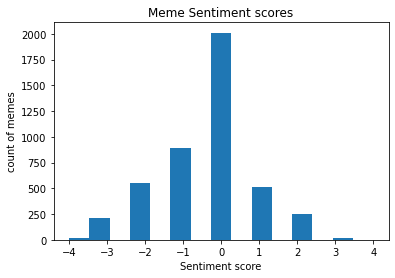

In [199]:
plt.hist(df['Sentiment_Scores'], bins = 15)
plt.title(f'Meme Sentiment scores')
plt.xlabel('Sentiment score')
plt.ylabel('count of memes')

(array([  5.,  97., 215.,   0., 351., 697.,   0., 157.,  57.,   4.]),
 array([-4.0, -3.3, -2.6, -1.9000000000000004, -1.2000000000000002, -0.5,
        0.1999999999999993, 0.8999999999999995, 1.5999999999999996, 2.3,
        3.0], dtype=object),
 <a list of 10 Patch objects>)

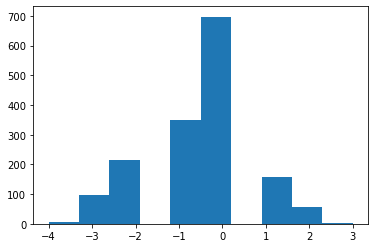

In [215]:
#grouping the dataset by party to get the average estimates of vocabulary for different parties
hate_df = df[df['Hate_label'] == 1]
plt.hist(hate_df['Sentiment_Scores'])
# plt.title('Avg vocabulary in different parties')

(array([6.000e+00, 1.430e+02, 4.070e+02, 6.400e+02, 0.000e+00, 1.362e+03,
        3.540e+02, 1.670e+02, 7.000e+00, 1.000e+00]),
 array([-4.0, -3.2, -2.4, -1.5999999999999996, -0.7999999999999998, 0.0,
        0.8000000000000007, 1.6000000000000005, 2.4000000000000004, 3.2,
        4.0], dtype=object),
 <a list of 10 Patch objects>)

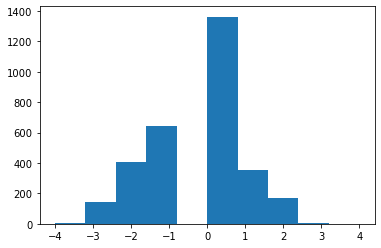

In [216]:
#grouping the dataset by party to get the average estimates of vocabulary for different parties
sarcasm_df = df[df['Sarcasm_label'] == 1]
plt.hist(sarcasm_df['Sentiment_Scores'])
# plt.title('Avg vocabulary in different parties')

From the sentiment analysis for overall dataset, hate only and sarcasm only, we can see that negative trend for overall and the sarcasm only is close enough, this could be because there is a lot of sarcasm in our memes(mostly abusive). Sentistrength has given us better insights than other tools like textblob or NLTK vader because sentistrength has been trained on short texts like tweets & internet slang

In [326]:
df = pd.read_csv('New_df.csv')